# Avaliando o impacto de uma política pública: **Propensity Score Matching** (*PSM*)

## Programa de Subsídios a Planos de Saúde (*Health Insurance Subsidy Program - HISP*)

Objetivo primário do programa: reduzir a despesa com itens relacionados a saúde para domicílios de baixa renda.

Variável de interesse: *health_expenditures*

----

## Leitura dos Dados

In [ ]:
## Já instalando bibliotecas necessárias
from IPython.display import clear_output # limpa o output de uma célula
!pip install linearmodels
!pip install CausalInference  # útil para fazer PSM automaticamente, mas não permite a mistura com DID
!pip uninstall scipy -y
!pip install scipy

clear_output()  # limpando o texto

In [ ]:
## Importando o que for necessário
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import ols, probit, logit
from patsy import dmatrices

In [ ]:
## Montando o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Lendo os dados
sCaminho = '/content/drive/MyDrive/Projetos/IDP/MBA/SetorPublicoII/Códigos/Aula 1 - 03_11_2021/'
sArquivo = "evaluation.dta"

## Lendo o DataFrame
df = pd.read_stata(f"{sCaminho}{sArquivo}")

# Vendo o tamanho da base
print(f"Linhas: {df.shape[0]}; Colunas: {df.shape[1]}")

Linhas: 19827; Colunas: 22


In [ ]:
## Vendo a descrição das variáveis (só funciona com arquivos .dta)
# Lendo novamente a base, mas agora com iterator, o que retorna um objeto do tipo StataReader
stata_reader = pd.read_stata(f"{sCaminho}{sArquivo}", iterator=True)

# Pegando as descrições das variáveis
descricoes = stata_reader.variable_labels()
descricoes

{'age_hh': 'Age of the head of the household (in years)',
 'age_sp': 'Age of the spouse (in years)',
 'bathroom': 'Home with private bathroom at baseline (0=no, 1=yes)',
 'dirtfloor': 'Home has a dirt floor at baseline (0=no, 1=yes)',
 'educ_hh': 'Education of the head of household (completed years of schooling)',
 'educ_sp': 'Education of the spouse (completed years of schooling)',
 'eligible': 'Household eligible to enroll in HISP (0=no, 1=yes)',
 'enrolled': 'HH enrolled in HISP (0=no, 1=yes)',
 'enrolled_rp': 'Household enrolled in HISP under the random promotion scenario (0=no, 1=yes)',
 'female_hh': 'Head of the household is a woman (0=no, 1=yes)',
 'health_expenditures': 'Out of pocket health expenditures (per person per year)',
 'hhsize': 'Number of household members (baseline)',
 'hospital': 'HH member visited hospital in the past year (0=no, 1=yes)',
 'hospital_distance': 'Distance to closest hospital',
 'household_identifier': 'Unique household identifier',
 'indigenous': 'H

In [ ]:
## Descrevendo o DataFrame
df.describe()

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
count,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,19827.000000,11257.000000
mean,73.933472,8038.965820,0.500277,0.512685,0.567761,0.299037,0.293287,56.789505,0.500025,17.035103,46.683117,40.581734,2.833550,2.618601,0.099057,0.352903,5.178645,0.603621,0.615978,2.079740,105.322517,0.052323
std,55.076599,4569.468262,0.500017,0.499851,0.495377,0.457822,0.455238,10.686106,0.500013,9.291589,15.294811,12.822810,2.754772,2.543370,0.298730,0.477869,2.195178,0.489157,0.486375,3.133202,42.063479,0.222696
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.479134,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.465392,0.000000
25%,30.000000,3989.500000,0.000000,0.000000,0.000000,0.000000,0.000000,49.652241,0.000000,11.621977,34.000000,31.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,72.804218,0.000000
50%,59.000000,8040.000000,1.000000,1.000000,1.000000,0.000000,0.000000,56.414219,1.000000,16.051678,45.000000,41.000000,2.000000,2.000000,0.000000,0.000000,5.000000,1.000000,1.000000,1.000000,113.556497,0.000000
75%,112.000000,12033.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.905720,1.000000,21.236842,58.000000,48.000000,4.000000,4.000000,0.000000,1.000000,7.000000,1.000000,1.000000,3.000000,141.097735,0.000000
max,200.000000,15778.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,116.830643,88.000000,88.000000,16.000000,17.000000,1.000000,1.000000,13.000000,1.000000,1.000000,23.000000,170.457647,1.000000


## Arrumando o dataset

Para que possamos usar o PSM, temos de ter todos os dados de um mesmo domicílio numa mesma linha (em ambos os períodos), ou seja, temos de colocar nosso DataFrame em um formato *longo*.

In [ ]:
## Vendo o dataset
df

,locality_identifier,household_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital
0,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
1,26.0,5.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0
2,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0
3,26.0,11.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0
4,26.0,13.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19822,35.0,15738.0,0.0,0.0,0.0,0.0,0.0,59.737247,0.0,16.811539,52.0,41.0,0.0,2.0,0.0,1.0,7.0,0,1,2,162.748811,NaN
19823,40.0,15769.0,1.0,1.0,0.0,0.0,0.0,62.055641,0.0,15.906003,51.0,40.0,5.0,2.0,0.0,1.0,5.0,1,1,1,114.763392,NaN
19824,40.0,15769.0,1.0,1.0,0.0,0.0,0.0,62.055641,1.0,8.248152,52.0,41.0,5.0,2.0,0.0,1.0,5.0,1,1,1,114.763392,NaN
19825,40.0,15778.0,1.0,1.0,0.0,0.0,0.0,62.828438,0.0,8.737772,58.0,49.0,3.0,0.0,0.0,1.0,9.0,1,1,4,114.763392,NaN


In [ ]:
## Pivottando, o que gera colunas com MultiIndex
# Para facilitar nossa vida, vamos retirar essas colunas com MultiIndex ao longo das próximas células
dfp = df.pivot(index='household_identifier', columns='round')
dfp

locality_identifier        ... hospital     
round                                0.0   1.0  ...      0.0  1.0
household_identifier                            ...              
2.0                                 26.0  26.0  ...      NaN  NaN
3.0                                 26.0  26.0  ...      NaN  NaN
5.0                                 26.0  26.0  ...      0.0  0.0
11.0                                26.0  26.0  ...      0.0  1.0
13.0                                26.0  26.0  ...      0.0  1.0
...                                  ...   ...  ...      ...  ...
15774.0                             40.0  40.0  ...      0.0  0.0
15775.0                             40.0  40.0  ...      0.0  0.0
15776.0                             40.0  40.0  ...      0.0  0.0
15777.0                             40.0  40.0  ...      0.0  0.0
15778.0                             40.0  40.0  ...      NaN  NaN

[9914 rows x 40 columns]

In [ ]:
## Criando uma lista com as colunas do dataset
lColunas = list(df.columns)
# Removendo o index (household_identifier) e a 1º nível da coluna (round)
lColunas.remove('household_identifier')
lColunas.remove('round')

## Fazendo uma nova lista com separação das variáveis entre round 0 e round 1
lNovasColunas = []
for sColuna in lColunas:
  for nNum in [0, 1]:
    lNovasColunas.append(f"{sColuna}_{nNum}")
  
## Vendo resultados
lNovasColunas[:6]

['locality_identifier_0',
 'locality_identifier_1',
 'treatment_locality_0',
 'treatment_locality_1',
 'promotion_locality_0',
 'promotion_locality_1']

In [ ]:
## Criando um novo DataFrame com os novos nomes das colunas e com os mesmos valores do anterior
dfp = pd.DataFrame(dfp.values, columns=lNovasColunas, index=dfp.index)
dfp

,locality_identifier_0,locality_identifier_1,treatment_locality_0,treatment_locality_1,promotion_locality_0,promotion_locality_1,eligible_0,eligible_1,enrolled_0,enrolled_1,enrolled_rp_0,enrolled_rp_1,poverty_index_0,poverty_index_1,health_expenditures_0,health_expenditures_1,age_hh_0,age_hh_1,age_sp_0,age_sp_1,educ_hh_0,educ_hh_1,educ_sp_0,educ_sp_1,female_hh_0,female_hh_1,indigenous_0,indigenous_1,hhsize_0,hhsize_1,dirtfloor_0,dirtfloor_1,bathroom_0,bathroom_1,land_0,land_1,hospital_distance_0,hospital_distance_1,hospital_0,hospital_1
household_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,26.0,26.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,73.840805,73.840805,21.700567,27.223108,66.0,67.0,69.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,124.819966,124.819966,NaN,NaN
3.0,26.0,26.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,60.973724,60.973724,24.372963,20.910048,63.0,64.0,59.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,3.0,3.0,124.819966,124.819966,NaN,NaN
5.0,26.0,26.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,55.950542,55.950542,15.185455,19.580902,24.0,25.0,23.0,24.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,124.819966,124.819966,0.0,0.0
11.0,26.0,26.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,46.058731,46.058731,13.076257,2.398854,30.0,31.0,26.0,27.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,2.0,2.0,124.819966,124.819966,0.0,1.0
13.0,26.0,26.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,54.095825,54.095825,15.286353,0.000000,58.0,59.0,56.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,4.0,4.0,124.819966,124.819966,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774.0,40.0,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.593508,28.593508,7.241524,7.193629,53.0,54.0,53.0,54.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,9.0,9.0,1.0,1.0,1.0,1.0,2.0,2.0,114.763392,114.763392,0.0,0.0
15775.0,40.0,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,37.171562,37.171562,10.391406,0.727366,29.0,30.0,27.0,28.0,1.0,1.0,6.0,6.0,0.0,0.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,114.763392,114.763392,0.0,0.0
15776.0,40.0,40.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.057186,29.057186,8.679602,0.000000,78.0,79.0,41.0,41.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,9.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,114.763392,114.763392,0.0,0.0


In [ ]:
## Retirando colunas que são iguais em ambos os períodos (mas mantendo o sufixo _0 nas que permanecem)
dfp.drop(columns=["locality_identifier_1", "treatment_locality_1", 
                   "promotion_locality_1", "eligible_1", 
                   "enrolled_1", "enrolled_rp_1"], inplace=True)

In [ ]:
## Para usar o PSM da forma correta, temos de tirar todos os valores nulos
## da nossa variável de interesse (health_expenditures)
# Vendo se tem algum valor nulo
print(dfp['health_expenditures_0'].isnull().value_counts())

False    9913
True        1
Name: health_expenditures_0, dtype: int64


In [ ]:
## Droppando os valores nulos
dfp.dropna(subset=['health_expenditures_0'], inplace=True)

# Vendo o novo tamanho do dataset
dfp.shape

(9913, 34)

In [ ]:
## Criando lista e fórmula com controles
# Lista (note os sufixos _0)
lControles = ["age_hh_0", "age_sp_0", "educ_hh_0", "educ_sp_0", "female_hh_0", "indigenous_0",
              "hhsize_0", "dirtfloor_0", "bathroom_0", "land_0", "hospital_distance_0"]

# Formulas
sControles = "age_hh_0 + age_sp_0 + educ_hh_0 + educ_sp_0 + female_hh_0 + indigenous_0 + hhsize_0 + dirtfloor_0 + bathroom_0 + land_0 + hospital_distance_0"
sControles

'age_hh_0 + age_sp_0 + educ_hh_0 + educ_sp_0 + female_hh_0 + indigenous_0 + hhsize_0 + dirtfloor_0 + bathroom_0 + land_0 + hospital_distance_0'

## Pareamento com PSM

De forma semelhante à DID, se usa o paramento quando o programa não possui regras de seleção claras, visando retirar vieses que surgiriam da diferença entre o grupo inscrito e o não-tratado.

O pareamento nada é mais que uma tecníca estatística para criar um grupo de comparação artificial: para cada unidade tratada, ele tenta encontrar uma unidade não-tratada (ou um conjunto de unidades) com as características mais semelhantes possíveis.

### Calculando o Propensity Score (probabilidade de a pessoa participar do tratamento)

O *propensity score* é uma métrica que mostra a probabilidade de uma unidade se inscrever no programa a partir de suas características **observáveis** no período pré-tratamento.

Dessa forma, a probabilidade resume a influência de todas as características observáveis sobre a probabilidade de se inscrever no programa.

Contudo, há a hipótese forte por trás de que **não há diferenças não observáveis** entre os grupos de tratamento e de comparação que estejam correlacionadas com a decisão de participar no programa.

#### Modelo Restrito

In [ ]:
## Criando o modelo probit para estimar a probabilidade
# O mesmo pode ser feito usando a Regressão Logística
# (ambos os modelos garantem resultados entre 0 e 1, o que é perfeito para probabilidades)

## Fórmula e modelo
formula_probit_simples = f"enrolled_0 ~ age_hh_0 + educ_hh_0"
modelo_probit_simples = probit(formula_probit_simples, dfp).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfp['locality_identifier_0']}
)

## Sumário
print(modelo_probit_simples.summary())

Optimization terminated successfully.
         Current function value: 0.587731
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:             enrolled_0   No. Observations:                 9913
Model:                         Probit   Df Residuals:                     9910
Method:                           MLE   Df Model:                            2
Date:                Sat, 13 Nov 2021   Pseudo R-squ.:                 0.03653
Time:                        01:06:54   Log-Likelihood:                -5826.2
converged:                       True   LL-Null:                       -6047.1
Covariance Type:              cluster   LLR p-value:                 1.148e-96
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5539      0.177      3.126      0.002       0.205       0.903
age_hh_0      -0.0214      0.

In [ ]:
## Adicionado ao DataFrame
dfp["propensity_score_simples"] = modelo_probit_simples.predict()

#### Modelo Completo

Como a adição de variáveis faz muita diferença na estimação do PSM, os resultados do modelo abaixo - que contém todos os controles - serão a base para todas as análises subsequentes.

In [ ]:
## Criando o modelo probit para estimar a probabilidade
# O mesmo pode ser feito usando a Regressão Logística (logit)
# (ambos os modelos garantem resultados entre 0 e 1, o que é perfeito para probabilidades)

## Fórmula e modelo
formula_probit = f"enrolled_0 ~ {sControles}"
modelo_probit = probit(formula_probit, dfp).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfp['locality_identifier_0']}
)

## Sumário
print(modelo_probit.summary())

Optimization terminated successfully.
         Current function value: 0.555485
         Iterations 5
                          Probit Regression Results                           
Dep. Variable:             enrolled_0   No. Observations:                 9913
Model:                         Probit   Df Residuals:                     9901
Method:                           MLE   Df Model:                           11
Date:                Sat, 13 Nov 2021   Pseudo R-squ.:                 0.08939
Time:                        01:07:16   Log-Likelihood:                -5506.5
converged:                       True   LL-Null:                       -6047.1
Covariance Type:              cluster   LLR p-value:                6.570e-225
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.4975      0.256     -1.946      0.053      -1.002       0.007
ag

In [ ]:
## Adicionado ao DataFrame
dfp["propensity_score"] = modelo_probit.predict()
dfp.head()

,locality_identifier_0,treatment_locality_0,promotion_locality_0,eligible_0,enrolled_0,enrolled_rp_0,poverty_index_0,poverty_index_1,health_expenditures_0,health_expenditures_1,age_hh_0,age_hh_1,age_sp_0,age_sp_1,educ_hh_0,educ_hh_1,educ_sp_0,educ_sp_1,female_hh_0,female_hh_1,indigenous_0,indigenous_1,hhsize_0,hhsize_1,dirtfloor_0,dirtfloor_1,bathroom_0,bathroom_1,land_0,land_1,hospital_distance_0,hospital_distance_1,hospital_0,hospital_1,propensity_score_simples,propensity_score
household_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2.0,26.0,1.0,1.0,0.0,0.0,0.0,73.840805,73.840805,21.700567,27.223108,66.0,67.0,69.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,124.819966,124.819966,NaN,NaN,0.195083,0.157273
3.0,26.0,1.0,1.0,0.0,0.0,0.0,60.973724,60.973724,24.372963,20.910048,63.0,64.0,59.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,3.0,3.0,124.819966,124.819966,NaN,NaN,0.213283,0.144142
5.0,26.0,1.0,1.0,1.0,1.0,1.0,55.950542,55.950542,15.185455,19.580902,24.0,25.0,23.0,24.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,124.819966,124.819966,0.0,0.0,0.515942,0.473980
11.0,26.0,1.0,1.0,1.0,1.0,0.0,46.058731,46.058731,13.076257,2.398854,30.0,31.0,26.0,27.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,2.0,2.0,124.819966,124.819966,0.0,1.0,0.400887,0.519653
13.0,26.0,1.0,1.0,1.0,1.0,0.0,54.095825,54.095825,15.286353,0.000000,58.0,59.0,56.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,4.0,4.0,124.819966,124.819966,0.0,1.0,0.245719,0.299889


O método de PSM tenta imitar a **seleção aleatória**, selecionando para o grupo de comparação as unidades com propensões semelhantes às das unidades do grupo de tratamento (método quasi-experimental).

Para isso, porém, é necessário que haja **suporte comum**, ou seja, indivíduos de ambos os grupos com probabilidades parecidas de participarem no programa. Vamos ver se isso ocorre:

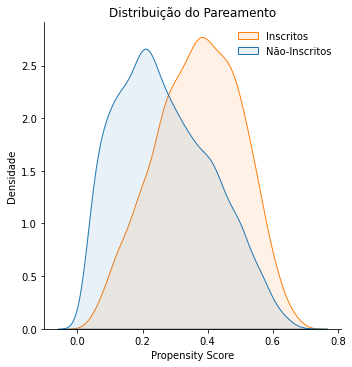

In [ ]:
## Plottando a distribuição

# Objeto gráfico
fig = plt.Figure(figsize=(10,10), dpi=200)

# Histograma e densidade
sns.displot(data=dfp, x='propensity_score', kind="kde",  # kde: plotta a densidade, não o histograma (kernel density estimation)
            hue='enrolled_0', common_norm=False,  # common_norm: faz com que a "altura" das densidades não seja dependente do número de observações
            fill=True, alpha=0.1, legend=False)

# Título
plt.title("Distribuição do Pareamento")
plt.xlabel("Propensity Score")
plt.ylabel("Densidade")
legenda = plt.legend(title='', loc='best', frameon=False,
                     labels=["Inscritos", "Não-Inscritos"])

Como vimos acima, há uma área significativa de sobreposição, ou seja, **há suporte comum**.

### Encontrando os pares mais próximos

In [ ]:
## Importando módulos necessários
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from causalinference import CausalModel

In [ ]:
## Separando domicílios que participaram do programa e aqueles que não
dfpTratados = dfp.query('enrolled_0 == 1')
dfpNaoTratados = dfp.query('enrolled_0 == 0')

In [ ]:
## Jeito errado
#pares = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(dfpNaoTratados['propensity_score'].values)
#distancia, indices = pares.kneighbors(dfpTratados['propensity_score'].values)

In [ ]:
## Jeito certo (colocando o reshape solicitado acima)
# Criando o objeto usando os dados dos não tratados
# Note que com n_neighbors=1, estamos selecionando no máximo 1 par para cada domicílio inscrito
pares = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(dfpNaoTratados['propensity_score'].values.reshape(-1, 1))

# Pareando com os valores do grupo dos tratados, o que resulta em uma tupla
    # distancia: diferença entre os propensity scores
    # indices: índice de um não-tratado pareado com o tratado (importante: está na ordem que os tratados aparecem)
distancia, indices = pares.kneighbors(dfpTratados['propensity_score'].values.reshape(-1, 1))

In [ ]:
## Vendo indices
# Passando para vetor (1D)
indices = indices.reshape(indices.shape[0])
# Vendo o resultado
indices

## O 1º domicílio tratado está pareado com o 968º não-tratado (e assim por diante)
# (atenção: esses números não são os household_identifiers, mas apenas o número da linha em dfpNaoTratados)

array([ 968, 1291, 1675, ..., 4856, 6776, 6945])

In [ ]:
## Vendo o número de domicílios não-inscritos pareados
indices.shape[0]

2964

In [ ]:
# Vendo o número de domicílios inscritos
dfpTratados.shape[0]

# Como os números são iguais, conseguimos o match de 1 pra 1!

2964

Importante: caso não se conseguisse o match de 1 pra 1, *indices* teria valores nulos (nan), cujas respectivas observações deveriam ser droppados de *dfpTratados*. 

Por exemplo, se em indices[2] houvesse um NaN, a 3ª linha de *dfpTratados* deveria ser droppada.

In [ ]:
## Pegando apenas os valores pareados entre os não-tratados
dfpPares = dfpNaoTratados.iloc[indices]
dfpPares

,locality_identifier_0,treatment_locality_0,promotion_locality_0,eligible_0,enrolled_0,enrolled_rp_0,poverty_index_0,poverty_index_1,health_expenditures_0,health_expenditures_1,age_hh_0,age_hh_1,age_sp_0,age_sp_1,educ_hh_0,educ_hh_1,educ_sp_0,educ_sp_1,female_hh_0,female_hh_1,indigenous_0,indigenous_1,hhsize_0,hhsize_1,dirtfloor_0,dirtfloor_1,bathroom_0,bathroom_1,land_0,land_1,hospital_distance_0,hospital_distance_1,hospital_0,hospital_1,propensity_score_simples,propensity_score
household_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2581.0,144.0,0.0,0.0,1.0,0.0,0.0,47.836166,47.836166,12.415433,12.220935,30.0,31.0,29.0,29.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,123.254698,123.254698,0.0,0.0,0.464741,0.474033
3372.0,9.0,1.0,1.0,0.0,0.0,0.0,59.041733,59.041733,10.263457,15.054167,36.0,37.0,24.0,25.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,8.0,8.0,1.0,1.0,1.0,1.0,0.0,0.0,143.908269,143.908269,NaN,NaN,0.322472,0.519654
4404.0,139.0,0.0,0.0,1.0,0.0,0.0,35.085007,35.085007,11.738947,11.843096,42.0,43.0,32.0,33.0,3.0,3.0,6.0,6.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,1.0,1.0,5.0,5.0,80.280560,80.280560,0.0,0.0,0.320124,0.299790
2983.0,185.0,0.0,1.0,1.0,0.0,0.0,48.145287,48.145287,10.439838,18.085072,37.0,38.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,163.996467,163.996467,0.0,0.0,0.405794,0.555113
13595.0,45.0,0.0,0.0,1.0,0.0,0.0,38.639877,38.639877,7.134558,16.030521,46.0,47.0,40.0,40.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,9.0,9.0,1.0,1.0,1.0,1.0,5.0,5.0,130.969992,130.969992,0.0,0.0,0.304199,0.536506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142.0,157.0,0.0,1.0,1.0,0.0,0.0,53.786709,53.786709,10.445128,51.810181,40.0,41.0,37.0,38.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,8.0,8.0,1.0,1.0,0.0,0.0,2.0,2.0,72.804218,72.804218,0.0,0.0,0.320906,0.469824
12153.0,18.0,0.0,0.0,0.0,0.0,0.0,58.809891,58.809891,8.741189,12.474454,51.0,51.0,46.0,47.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,32.103214,32.103214,NaN,NaN,0.267820,0.456277
11480.0,43.0,0.0,0.0,1.0,0.0,0.0,45.208656,45.208656,12.015872,14.070844,23.0,24.0,21.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,34.387380,34.387380,0.0,0.0,0.524473,0.540679


In [ ]:
## Vendo se a ordem está correta (será útil no DID x PSM)
dfpNaoTratados.iloc[indices[:4]]

# A 1ª linha de dfpPares corresponde ao par da 1ª linha do dfpTratados, a 2ª com a 2ª... e assim sucessivamente

,locality_identifier_0,treatment_locality_0,promotion_locality_0,eligible_0,enrolled_0,enrolled_rp_0,poverty_index_0,poverty_index_1,health_expenditures_0,health_expenditures_1,age_hh_0,age_hh_1,age_sp_0,age_sp_1,educ_hh_0,educ_hh_1,educ_sp_0,educ_sp_1,female_hh_0,female_hh_1,indigenous_0,indigenous_1,hhsize_0,hhsize_1,dirtfloor_0,dirtfloor_1,bathroom_0,bathroom_1,land_0,land_1,hospital_distance_0,hospital_distance_1,hospital_0,hospital_1,propensity_score_simples,propensity_score
household_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2581.0,144.0,0.0,0.0,1.0,0.0,0.0,47.836166,47.836166,12.415433,12.220935,30.0,31.0,29.0,29.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,123.254698,123.254698,0.0,0.0,0.464741,0.474033
3372.0,9.0,1.0,1.0,0.0,0.0,0.0,59.041733,59.041733,10.263457,15.054167,36.0,37.0,24.0,25.0,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,8.0,8.0,1.0,1.0,1.0,1.0,0.0,0.0,143.908269,143.908269,NaN,NaN,0.322472,0.519654
4404.0,139.0,0.0,0.0,1.0,0.0,0.0,35.085007,35.085007,11.738947,11.843096,42.0,43.0,32.0,33.0,3.0,3.0,6.0,6.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0,0.0,1.0,1.0,5.0,5.0,80.280560,80.280560,0.0,0.0,0.320124,0.299790
2983.0,185.0,0.0,1.0,1.0,0.0,0.0,48.145287,48.145287,10.439838,18.085072,37.0,38.0,30.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,163.996467,163.996467,0.0,0.0,0.405794,0.555113


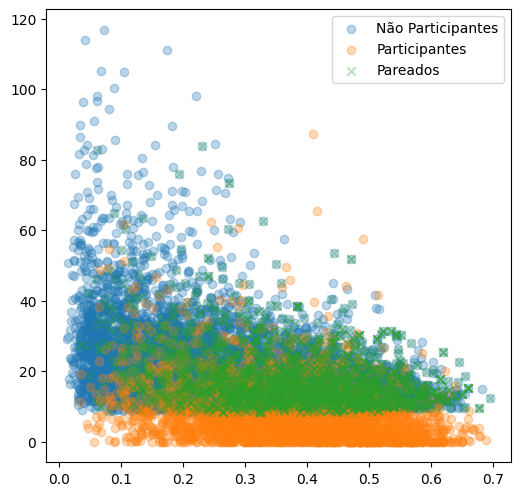

In [ ]:
## Plottando um scatterplot para ver quem foram os pareados
# Objeto gráfico
fig, ax = plt.subplots(figsize=(6,6), dpi=100)
# Todos os Não-Inscritos
plt.scatter(dfpNaoTratados['propensity_score'], dfpNaoTratados['health_expenditures_1'], 
            alpha=0.3, label='Não Participantes')
# Inscritos
plt.scatter(dfpTratados['propensity_score'], dfpTratados['health_expenditures_1'], 
            alpha=0.3,label='Participantes')
# Pareados
plt.scatter(dfpPares['propensity_score'], dfpPares['health_expenditures_1'], 
            marker='x', label='Pareados', alpha=0.3)
# Colocando legenda
plt.legend()

In [ ]:
## Concatenando verticalmente os tratados com os pareados
dfpParesTratados = pd.concat([dfpTratados, dfpPares], axis=0)

# Vendo o resultado
dfpParesTratados

,locality_identifier_0,treatment_locality_0,promotion_locality_0,eligible_0,enrolled_0,enrolled_rp_0,poverty_index_0,poverty_index_1,health_expenditures_0,health_expenditures_1,age_hh_0,age_hh_1,age_sp_0,age_sp_1,educ_hh_0,educ_hh_1,educ_sp_0,educ_sp_1,female_hh_0,female_hh_1,indigenous_0,indigenous_1,hhsize_0,hhsize_1,dirtfloor_0,dirtfloor_1,bathroom_0,bathroom_1,land_0,land_1,hospital_distance_0,hospital_distance_1,hospital_0,hospital_1,propensity_score_simples,propensity_score
household_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5.0,26.0,1.0,1.0,1.0,1.0,1.0,55.950542,55.950542,15.185455,19.580902,24.0,25.0,23.0,24.0,0.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,1.0,1.0,124.819966,124.819966,0.0,0.0,0.515942,0.473980
11.0,26.0,1.0,1.0,1.0,1.0,0.0,46.058731,46.058731,13.076257,2.398854,30.0,31.0,26.0,27.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,2.0,2.0,124.819966,124.819966,0.0,1.0,0.400887,0.519653
13.0,26.0,1.0,1.0,1.0,1.0,0.0,54.095825,54.095825,15.286353,0.000000,58.0,59.0,56.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,1.0,1.0,0.0,0.0,4.0,4.0,124.819966,124.819966,0.0,1.0,0.245719,0.299889
16.0,26.0,1.0,1.0,1.0,1.0,1.0,56.903400,56.903400,11.311761,20.026909,35.0,36.0,24.0,25.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,1.0,1.0,0.0,0.0,2.0,2.0,124.819966,124.819966,0.0,0.0,0.375443,0.555568
21.0,26.0,1.0,1.0,1.0,1.0,1.0,46.908810,46.908810,11.223912,16.664686,37.0,39.0,35.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,1.0,1.0,0.0,0.0,2.0,2.0,124.819966,124.819966,0.0,0.0,0.405794,0.536349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8142.0,157.0,0.0,1.0,1.0,0.0,0.0,53.786709,53.786709,10.445128,51.810181,40.0,41.0,37.0,38.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,8.0,8.0,1.0,1.0,0.0,0.0,2.0,2.0,72.804218,72.804218,0.0,0.0,0.320906,0.469824
12153.0,18.0,0.0,0.0,0.0,0.0,0.0,58.809891,58.809891,8.741189,12.474454,51.0,51.0,46.0,47.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.0,1.0,1.0,1.0,1.0,1.0,1.0,32.103214,32.103214,NaN,NaN,0.267820,0.456277
11480.0,43.0,0.0,0.0,1.0,0.0,0.0,45.208656,45.208656,12.015872,14.070844,23.0,24.0,21.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,34.387380,34.387380,0.0,0.0,0.524473,0.540679


### Encontrando o efeito local do tratamento nos tratados



In [ ]:
## Regredindo sobre os dados de tratados e não-inscritos PAREADOS
# Formula
formula_psm = "health_expenditures_1 ~ enrolled_0 + propensity_score"

# Modelo com covariância clusterizada
modelo_psm = ols(formula_psm, dfpParesTratados).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfpParesTratados['locality_identifier_0']}
)

# Printando o modelo: o efeito do tratamento é medido pelo coeficiente de enrolled_0
print(modelo_psm.summary())

                              OLS Regression Results                             
Dep. Variable:     health_expenditures_1   R-squared:                       0.353
Model:                               OLS   Adj. R-squared:                  0.353
Method:                    Least Squares   F-statistic:                     634.4
Date:                   Sat, 13 Nov 2021   Prob (F-statistic):           1.39e-85
Time:                           01:11:06   Log-Likelihood:                -20416.
No. Observations:                   5928   AIC:                         4.084e+04
Df Residuals:                       5925   BIC:                         4.086e+04
Df Model:                              2                                         
Covariance Type:                 cluster                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept 

Fizemos todo o processo na mão - o que será útil na hora de aplicar o DID -, mas, caso estivéssemos muito confiantes que não há nenhuma diferença não-observável que afeta a participação, poderíamos usar diretamente a função CausalModel da biblioteca causalinference.

In [ ]:
## Fazendo automaticamente
# Note: D é uma notação comumente usada para denominar a variável de tratamento

# Criando o modelo
cm = CausalModel(
    Y=dfp["health_expenditures_1"].values, 
    D=dfp["enrolled_0"].values, 
    X=dfp[["propensity_score"]].values
)

## Estimando
# matches: máximo de 1 par para cada inscrito
cm.est_via_matching(matches=1, bias_adj=True)

# Printando o sumário: estamos interessados no coeficiente ATT (efeito médio do tratamento nos tratados)
# ATT: average treatment effect on the treated - igual ao coeficiente de enrolled_0 acima.
print(cm.estimates)

/usr/local/lib/python3.7/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    -10.620      0.359    -29.544      0.000    -11.325     -9.916
           ATC    -10.904      0.420    -25.947      0.000    -11.728    -10.080
           ATT     -9.955      0.408    -24.408      0.000    -10.754     -9.155



### DID com Pareamento

Os resultados acima (de o efeito do HISP ser de reduzir as despesas em ≈ US$ 9.95 por pessoa por ano) dependem da forte hipótese de que não há nenhuma diferença não-observável entre os grupos de controle e de tratamento que também afetam os resultados de interesse (gastos com saúde no período pós-programa).

Além disso, a estimativa é altamente dependente nas características usadas para estimar o PSM no modelo *probit* (sem o set completo de controles, nossas estimativas seriam de mais de US$ 11 - podem testar depois!), ou seja, pode haver algum viés caso não formos cuidados o suficiente.

**Dessa forma, geralmente se usa o pareamento quando as opções de seleção aleatória, VIs e RDD estão *indisponíveis*.**

Quando temos dados do período pré-tratamento, podemos controlar para as diferenças não-observáveis, o que não é possível com o pareamento puro. 

Para isso, combinamos o método com o **DID** (e por isso também precisamos estimar tudo na mão, ao invés de usar o CausalModel direto).

Importante: com isso, controlamos para diferenças não-observáveis que sejam **constantes** ao longo do tempo entre os dois grupos - ainda estamos sucetíveis a vieses de diferenças não-observáveis que variam no tempo.

#### Arrumando os dados

Para aplicar o *DID* junto com *PSM*, temos de ter os gastos com saúde em ambos os períodos e as probabilidades de cada dupla inscrito-par **em uma mesma linha**.

In [ ]:
## Inicialmente, devemos pegar os gastos do par mais próximo tanto no período
## pré quanto no pós-programa; para isso, usaremos o dfpPares criando a partir da variável indices

## O que ajuda muito é a forma como indices é gerada pelo sklearn: ela pareia o 1º domicílio com algum não-inscrito,
## o 2º domicílio com algum outro, etc, mas faz isso na ordem correta.

dfpTratados['propensity_score_match'] = dfpPares['propensity_score'].values
dfpTratados['health_expenditures_match_0'] = dfpPares['health_expenditures_0'].values
dfpTratados['health_expenditures_match_1'] = dfpPares['health_expenditures_1'].values

clear_output()

In [ ]:
## Vendo o resultado
dfpTratados[['health_expenditures_0', 'health_expenditures_match_0',
             'health_expenditures_1', 'health_expenditures_match_1',
             'propensity_score', 'propensity_score_match']]

,health_expenditures_0,health_expenditures_match_0,health_expenditures_1,health_expenditures_match_1,propensity_score,propensity_score_match
household_identifier,,,,,,
5.0,15.185455,12.415433,19.580902,12.220935,0.473980,0.474033
11.0,13.076257,10.263457,2.398854,15.054167,0.519653,0.519654
13.0,15.286353,11.738947,0.000000,11.843096,0.299889,0.299790
16.0,11.311761,10.439838,20.026909,18.085072,0.555568,0.555113
21.0,11.223912,7.134558,16.664686,16.030521,0.536349,0.536506
...,...,...,...,...,...,...
15773.0,7.218568,10.445128,0.000000,51.810181,0.469780,0.469824
15774.0,7.241524,8.741189,7.193629,12.474454,0.456285,0.456277
15775.0,10.391406,12.015872,0.727366,14.070844,0.540780,0.540679


#### Calculando as Primeiras e Segundas Diferenças usando os dados acima

In [ ]:
## Média dos inscritos antes e depois (primeira diferença)
# Médias de cada período
nMediaInscritos0 = dfpTratados['health_expenditures_0'].mean()
nMediaInscritos1 = dfpTratados['health_expenditures_1'].mean()
nPrimeiraDiferença = nMediaInscritos1 - nMediaInscritos0

# Printando
print(f"Média dos Inscritos Pré-Tratamento: US$ {round(nMediaInscritos0, 2)}")
print(f"Média dos Inscritos Pós-Tratamento: US$ {round(nMediaInscritos1, 2)}")
print(f"Primeira Diferença: US$ {round(nPrimeiraDiferença, 2)}")

Média dos Inscritos Pré-Tratamento: US$ 14.49
Média dos Inscritos Pós-Tratamento: US$ 7.84
Primeira Diferença: US$ -6.65


In [ ]:
## Média dos NÃO inscritos PAREADOS antes e depois (segunda diferença)

# Médias de cada período
nMediaNaoInscritos0 = dfpTratados['health_expenditures_match_0'].mean()
nMediaNaoInscritos1 = dfpTratados['health_expenditures_match_1'].mean()
nSegundaDiferença = nMediaNaoInscritos1 - nMediaNaoInscritos0

# Printando
print(f"Média dos Não-Inscritos Pré-Tratamento: US$ {round(nMediaNaoInscritos0, 2)}")
print(f"Média dos Não-Inscritos Pós-Tratamento: US$ {round(nMediaNaoInscritos1, 2)}")
print(f"Segunda Diferença: US$ {round(nSegundaDiferença, 2)}")

Média dos Não-Inscritos Pré-Tratamento: US$ 15.04
Média dos Não-Inscritos Pós-Tratamento: US$ 17.79
Segunda Diferença: US$ 2.76


In [ ]:
## Vendo a diferença em diferenças
nDID = nPrimeiraDiferença - nSegundaDiferença
print(f"Diferença em Diferenças Pareadas: US$ {round(nDID, 4)}")

# Comparando com o resultado obtido anteriormente (-US$ 9.95), o efeito do tratamento sobre os tratados parece ter sido menor

# Contudo, ele é maior que a estimativa pura de DID (-US$ 8.16) e que a de RDD (-US$ 9), 
# mas ainda é menor que o efeito médio GERAL encontrado de -US$ 10 usando seleção aleatória e de -US$ 9.74 (LATE) encontrado usando VIs.

Diferença em Diferenças Pareadas: US$ -9.409


#### Modelo de Regressão DID

Y = B<sub>0</sub> + B<sub>1</sub>t + B<sub>2</sub>T + B<sub>3</sub>t*T + B<sub>4</sub>X, onde

- *t* indica se a observação é do período pré (0) ou pós-tratamento (1);
- *T* indica se a observação pertence ao grupo tratado.
- *X* é um vetor que representa as demais variáveis.

B<sub>1</sub> é um coeficiente que capta mudança temporais globais (que afetam ambos os grupos), e pode ser chamado de **efeito do tratamento nos não-tratados** (a segunda diferença acima).

B<sub>1</sub> + B<sub>3</sub> capta as mudanças temporais totais no grupo tratado, sendo chamado de **efeito do tratamento nos tratados** (primeira diferença acima). Além disso, B<sub>2</sub> controla para qualquer diferença pré-existente entre os grupos.

O **efeito do tratamento** é, portanto, B<sub>3</sub> (diferença em diferenças).





In [ ]:
## Como DID exige um dataset no formato "comum" (e não pivottado) - como é o nosso df original -, 
## precisamos sinalizar quais são os domicílios não-tratados que foram pareados

# Criando uma coluna auxiliar que diz se o domicílio
# a) participou do programa
# b) foi pareado com algum que participou
dfpParesTratados['match_enrolled'] = 1

# Lembre-se: esse DataFrame contém os inscritos e pares a partir do modelo probit com todos os controles

In [ ]:
## Colocando a identificação do domicílio como index
df = df.set_index('household_identifier')

## Joinando os dois dataframes
dfParesTratados = df.join(dfpParesTratados['match_enrolled'], how='left')

## Pegando apenas aqueles que participaram do programa ou foram pareados
dfParesTratados = dfParesTratados.query('match_enrolled == 1')

# Vendo o resultado
dfParesTratados

,locality_identifier,treatment_locality,promotion_locality,eligible,enrolled,enrolled_rp,poverty_index,round,health_expenditures,age_hh,age_sp,educ_hh,educ_sp,female_hh,indigenous,hhsize,dirtfloor,bathroom,land,hospital_distance,hospital,match_enrolled
household_identifier,,,,,,,,,,,,,,,,,,,,,,
5.0,26.0,1.0,1.0,1.0,1.0,1.0,55.950542,0.0,15.185455,24.0,23.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0,1.0
5.0,26.0,1.0,1.0,1.0,1.0,1.0,55.950542,1.0,19.580902,25.0,24.0,0.0,6.0,0.0,0.0,4.0,1,0,1,124.819966,0.0,1.0
11.0,26.0,1.0,1.0,1.0,1.0,0.0,46.058731,0.0,13.076257,30.0,26.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,0.0,1.0
11.0,26.0,1.0,1.0,1.0,1.0,0.0,46.058731,1.0,2.398854,31.0,27.0,4.0,0.0,0.0,0.0,6.0,1,0,2,124.819966,1.0,1.0
13.0,26.0,1.0,1.0,1.0,1.0,0.0,54.095825,1.0,0.000000,59.0,57.0,0.0,0.0,0.0,0.0,6.0,1,0,4,124.819966,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15776.0,40.0,1.0,1.0,1.0,1.0,1.0,29.057186,1.0,0.000000,79.0,41.0,0.0,2.0,0.0,1.0,9.0,1,0,0,114.763392,0.0,1.0
15777.0,40.0,1.0,1.0,1.0,1.0,1.0,38.485317,1.0,0.000000,32.0,26.0,4.0,2.0,0.0,1.0,6.0,1,0,0,114.763392,0.0,1.0
15777.0,40.0,1.0,1.0,1.0,1.0,1.0,38.485317,0.0,10.106905,31.0,25.0,4.0,2.0,0.0,1.0,6.0,1,0,0,114.763392,0.0,1.0


In [ ]:
## Modelo simples
# Formula
formula_simples_did = "health_expenditures ~ 1 + round*enrolled"

# Modelo
modelo_simples_did = ols(formula_simples_did, data=dfParesTratados).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfParesTratados['locality_identifier']}
)

# Sumário
print(modelo_simples_did.summary())

# Mesma estimativa do cálculo usando médias!

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.238
Model:                             OLS   Adj. R-squared:                  0.238
Method:                  Least Squares   F-statistic:                     372.3
Date:                 Sat, 13 Nov 2021   Prob (F-statistic):           5.70e-80
Time:                         01:12:36   Log-Likelihood:                -39086.
No. Observations:                11856   AIC:                         7.818e+04
Df Residuals:                    11852   BIC:                         7.821e+04
Df Model:                            3                                         
Covariance Type:               cluster                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.0354      0.2

In [ ]:
## Modelo mais completo
# String de controles
sControlesDID = "age_hh + age_sp + educ_hh + educ_sp + female_hh + indigenous + hhsize + dirtfloor + bathroom + land + hospital_distance"
# Formula
formula_did = f"{formula_simples_did} + {sControlesDID}"

# Modelo
modelo_did = ols(formula_did, data=dfParesTratados).fit(
    use_t=True,
    cov_type='cluster',
    cov_kwds={'groups':dfParesTratados['locality_identifier']}
)

# Sumário
print(modelo_did.summary())

# Estimativa quase idêntica à obtida acima!

                             OLS Regression Results                            
Dep. Variable:     health_expenditures   R-squared:                       0.523
Model:                             OLS   Adj. R-squared:                  0.522
Method:                  Least Squares   F-statistic:                     453.5
Date:                 Sat, 13 Nov 2021   Prob (F-statistic):          2.52e-139
Time:                         01:12:57   Log-Likelihood:                -36313.
No. Observations:                11856   AIC:                         7.266e+04
Df Residuals:                    11841   BIC:                         7.277e+04
Df Model:                           14                                         
Covariance Type:               cluster                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            24.6871

# Obrigado e Bom Sábado a Todos!